In [1]:
!wget https://raw.githubusercontent.com/dsrscientist/DSData/master/Telecom_customer_churn.csv -O telco_churn.csv


--2025-03-22 08:14:02--  https://raw.githubusercontent.com/dsrscientist/DSData/master/Telecom_customer_churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977501 (955K) [text/plain]
Saving to: ‘telco_churn.csv’

telco_churn.csv     100%[===================>] 954.59K  --.-KB/s    in 0.06s   

2025-03-22 08:14:02 (16.2 MB/s) - ‘telco_churn.csv’ saved [977501/977501]



In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from skopt import BayesSearchCV



In [4]:
# Step 1: Load the Dataset

df = pd.read_csv("telco_churn.csv")


In [5]:
# Display the features
print(df.head())  # Display first few rows
print(df.info())  # Show dataset details


   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [6]:
print(df.dtypes)


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [7]:
# Step 2: Data Preprocessing
# Drop irrelevant columns (e.g., customer ID)
df.drop(columns=['customerID'], inplace=True, errors='ignore')

In [8]:
print(df.isnull().sum())


gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [9]:
## Convert TotalCharges to numeric (handling errors)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.fillna(df.select_dtypes(include=[np.number]).median(), inplace=True)

In [10]:
# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [11]:
# Step 3: Splitting Data
X = df.drop(columns=['Churn'])  # Features
y = df['Churn']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Step 4: Feature Scaling (Only After Splitting)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

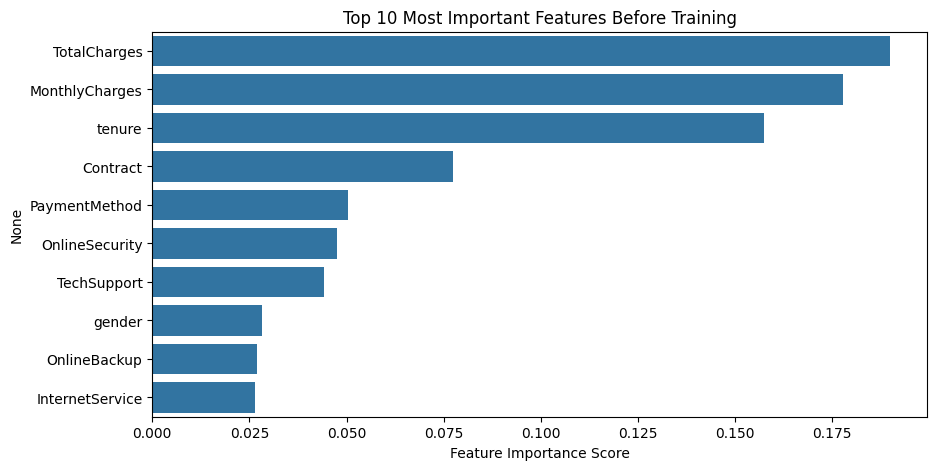

In [13]:
# Step 5: Feature Importance Analysis Before Training
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_train, y_train)
feature_importance = pd.Series(rf_temp.feature_importances_, index=X.columns).sort_values(ascending=False)


plt.figure(figsize=(10,5))
sns.barplot(x=feature_importance[:10], y=feature_importance.index[:10])
plt.title("Top 10 Most Important Features Before Training")
plt.xlabel("Feature Importance Score")
plt.show()

<ipython-input-15-db9429907f47>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='coolwarm')


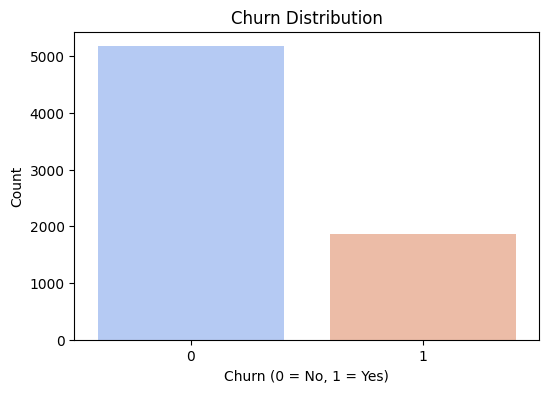

In [15]:
# Step 6: Additional Visualizations Before Training
# 1. Churn Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y, palette='coolwarm')
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

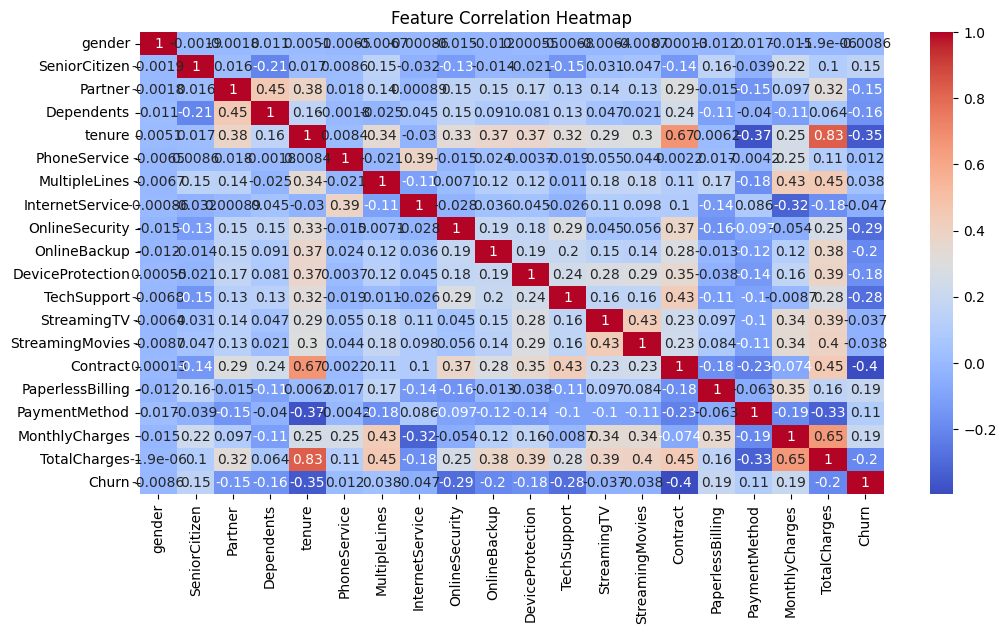

In [16]:
# 2. Correlation Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


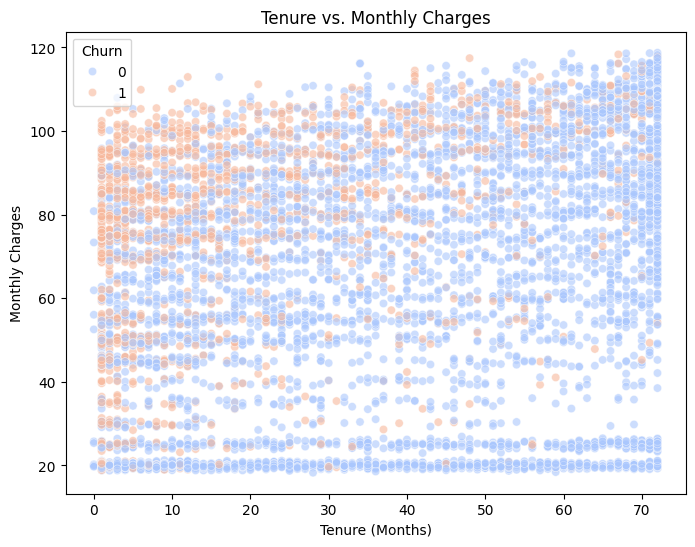

In [17]:
# 3. Tenure vs. Monthly Charges Scatter Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['tenure'], y=df['MonthlyCharges'], hue=df['Churn'], palette='coolwarm', alpha=0.6)
plt.title("Tenure vs. Monthly Charges")
plt.xlabel("Tenure (Months)")
plt.ylabel("Monthly Charges")
plt.show()

In [14]:
# Step 6: Select Top 15 Features
selected_features = feature_importance[:15].index
X_train = X_train[selected_features]
X_test = X_test[selected_features]


In [18]:
# Step 7: Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [19]:
# Step 8: Hyperparameter Tuning for XGBoost and LGBM
xgb = XGBClassifier(random_state=42)
lgbm = LGBMClassifier(random_state=42)
param_grid = {
    'learning_rate': (0.01, 0.3),
    'max_depth': (3, 10),
    'n_estimators': (50, 300),
    'subsample': (0.6, 1.0)
}
search_xgb = BayesSearchCV(xgb, param_grid, n_iter=30, cv=3, n_jobs=-1, random_state=42)
search_lgbm = BayesSearchCV(lgbm, param_grid, n_iter=30, cv=3, n_jobs=-1, random_state=42)
search_xgb.fit(X_train_resampled, y_train_resampled)
search_lgbm.fit(X_train_resampled, y_train_resampled)

[LightGBM] [Info] Number of positive: 4138, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 8276, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


BayesSearchCV(cv=3, estimator=LGBMClassifier(random_state=42), n_iter=30,
              n_jobs=-1, random_state=42,
              search_spaces={'learning_rate': (0.01, 0.3), 'max_depth': (3, 10),
                             'n_estimators': (50, 300),
                             'subsample': (0.6, 1.0)})

In [31]:
# Step 9: Train Optimized Models
best_xgb = search_xgb.best_estimator_
best_lgbm = search_lgbm.best_estimator_
best_xgb.fit(X_train_resampled, y_train_resampled)
best_lgbm.fit(X_train_resampled, y_train_resampled)

[LightGBM] [Info] Number of positive: 4138, number of negative: 4138
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 8276, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(learning_rate=0.11569843470521436, max_depth=9, n_estimators=86,
               random_state=42, subsample=0.6004712348662355)

In [21]:
# Step 10: Train Random Forest and Gradient Boosting
rf = RandomForestClassifier(n_estimators=300, max_depth=7, random_state=42)
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
gb.fit(X_train_resampled, y_train_resampled)


GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=300,
                           random_state=42)

In [24]:
# Step 12: Voting Classifier (Ensemble Averaging)
voting_model = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb), ('xgb', best_xgb), ('lgbm', best_lgbm)],
    voting='soft'
)
voting_model.fit(X_train_resampled, y_train_resampled)


[LightGBM] [Info] Number of positive: 4138, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 8276, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=7,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=5,
                                                         n_estimators=300,
                                                         random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            ea...
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=155, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('lgbm',
                              LGBMClassifier(learning_rate=0.11569843470521436,
                                             max_depth=9, n_estimators=86,
                                             random_state=42,
                                             subsample=0.6004712348662355))],
                 voting='soft')

In [32]:
# Step 10: Train Additional Models
rf = RandomForestClassifier(n_estimators=300, max_depth=7, random_state=42)
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
dt = DecisionTreeClassifier(max_depth=6, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
gb.fit(X_train_resampled, y_train_resampled)
dt.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(max_depth=6, random_state=42)

In [26]:
# Step 11: Stacking Classifier
stacked_model = StackingClassifier(
    estimators=[('rf', rf), ('gb', gb), ('xgb', best_xgb)], final_estimator=XGBClassifier()
)
stacked_model.fit(X_train_resampled, y_train_resampled)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=6,
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(max_depth=4,
                                                           n_estimators=200,
                                                           random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_roun...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...))

In [33]:
# Step 13: Evaluate Models
y_pred_stacked = stacked_model.predict(X_test)
y_pred_voting = voting_model.predict(X_test)
y_pred_dt = dt.predict(X_test)

stacked_accuracy = accuracy_score(y_test, y_pred_stacked)
voting_accuracy = accuracy_score(y_test, y_pred_voting)
dt_accuracy = accuracy_score(y_test, y_pred_dt)



In [34]:
print(f"Stacked Model Accuracy: {stacked_accuracy:.4f}")
print("Classification Report for Stacked Model:")
print(classification_report(y_test, y_pred_stacked))

print(f"Voting Model Accuracy: {voting_accuracy:.4f}")
print("Classification Report for Voting Model:")
print(classification_report(y_test, y_pred_voting))

print(f"Decision Tree Model Accuracy: {dt_accuracy:.4f}")
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_pred_dt))

Stacked Model Accuracy: 0.7892
Classification Report for Stacked Model:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1036
           1       0.60      0.59      0.60       373

    accuracy                           0.79      1409
   macro avg       0.73      0.72      0.73      1409
weighted avg       0.79      0.79      0.79      1409

Voting Model Accuracy: 0.8006
Classification Report for Voting Model:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1036
           1       0.61      0.71      0.65       373

    accuracy                           0.80      1409
   macro avg       0.75      0.77      0.76      1409
weighted avg       0.81      0.80      0.81      1409

Decision Tree Model Accuracy: 0.7594
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      1036
           1     

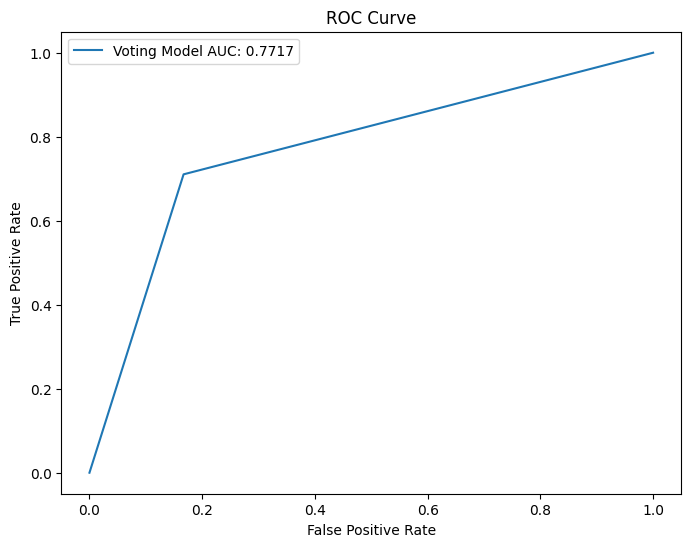

In [35]:
# Step 14: ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_voting)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Voting Model AUC: {roc_auc_score(y_test, y_pred_voting):.4f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()